In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


design_data=pd.read_excel("bedwidth_corrected.xlsx")
# The columns are 'bedwith' (base width of the design section), 'offset' (base width of the design section on eithside from 
# the center), "CL_RL" (reduced level or elevation of the design base)
design_data.head()

,CH,bedwidth,OFFSET,CL_RL
0,-500,350,175.0,1.0
1,-450,350,175.0,1.0
2,-400,350,175.0,1.0
3,-350,350,175.0,1.0
4,-300,350,175.0,1.0


In [2]:
# This data file containd the elevations of the prework and postwork sections at every chainage. For every two columns with
# the same name, the first column is the prework section and ther second column is the postwork section. The first column of 
# the dataframe is the distances where elevation data are available. Except for the column named "Distance", the columns names
# are the chainages where dredging work was done
d1=pd.read_excel("data.xlsx")

In [3]:
d_all={} # A dictionary to contain the initial and final dataframe and other information for every cross section
d_columns = d1.columns
sec_per_d1 = (len(d_columns)-1)/2
d_column_num = np.arange(1, len(d_columns)-1, 2)
d_sections = d_columns[d_column_num]

inde=1
for i in d_sections:
    index=design_data[design_data["CH"]==i].index[0]
    d_all[i] = {"chaingae" : i,  # cross section number in the target dredging area
              "base" : design_data.iloc[index,3], # desired base elevation of the postwork
              "OFFSET" : design_data.iloc[index,2], # length of base on either side from center of design section
              "df" : d1.iloc[:,[0,inde,inde+1]]}

    inde+=2

In [4]:
d_all

{-500: {'chaingae': -500,
  'base': 1.0,
  'OFFSET': 175.0,
  'df':     Distance  -500  -500.1
  0       -200  0.73    3.00
  1       -190  0.71    2.98
  2       -180  0.71    2.98
  3       -170  0.65    2.95
  4       -160  0.83    2.99
  5       -150  1.36    3.08
  6       -140  0.77    3.14
  7       -130  1.22    3.26
  8       -120  1.45    3.37
  9       -110  0.95    3.29
  10      -100  1.27    3.13
  11       -90  1.50    3.02
  12       -80  1.74    2.99
  13       -70  1.95    2.95
  14       -60  1.96    2.88
  15       -50  2.14    2.80
  16       -40  2.07    2.64
  17       -30  2.33    2.42
  18       -20  2.58    2.13
  19       -10  2.56    1.34
  20         0  2.43    1.87
  21        10  2.86    3.01
  22        20  2.75    3.24
  23        30  2.86    3.26
  24        40  3.00    3.25
  25        50  2.94    3.26
  26        60  2.96    3.34
  27        70  2.94    2.97
  28        80  3.01    2.32
  29        90  2.81    2.60
  30       100  3.01    2.84
  31  

In [5]:
for key in d_all:    
    a=d_all[key]["df"].copy()

    a.rename(columns={ a.columns[1]: "postwork" }, inplace = True)
    a.rename(columns={ a.columns[2]: "prework" }, inplace = True)

    offset=d_all[key]["OFFSET"]
    if offset not in a["Distance"].unique(): #If the starting and end point of the design base line is not on the available 
                                             # distances they are added in the dataframe
        positive_row = {"Distance":offset}
        negative_row = {"Distance":-offset}

        a= a.append(positive_row,ignore_index=True)
        a= a.append(negative_row,ignore_index=True)

        a= a.sort_values(by=['Distance']).reset_index(drop=True)

        a= a.interpolate(method='linear', axis=0).ffill().bfill()

    p_index=int(a[a['Distance']==offset].index.values)  # end point of the design baseline
    n_index=int(a[a['Distance']==-offset].index.values) # starting point of the design baseline
    l_index=a.shape[0]-1                                # number of points along the cross section  

## PREPARING DESIGN SECTION 
    # The design section has a base at given elevation ("base" in current dictionary), with length 2 X offset
    a.insert(loc=3, column='design_section', value=d_all[key]["base"])
    
    # the slope is 1:3 on either side from the edges of the base
    j=n_index-1
    while j>=0:
        a.loc[j,"design_section"]= a["design_section"][n_index] + (1/3)*abs(a["Distance"][n_index]-a["Distance"][j])
        j=j-1

    k=p_index+1
    while k<=l_index:
        a.loc[k,"design_section"] = a["design_section"][n_index] + (1/3)*abs(a["Distance"][p_index]-a["Distance"][k])
        k=k+1

## FIXING POSTWORK by creating workable postwork where no postwork is above the prework and postwork that is 
##just below the prework for a stretched legth is dragged to prework

    a["workable_post"]=a["postwork"]
    
    # If the postwork gets above prework because of sedementation on the sides of the bank, the elevation of postwork in
    # this area is replaced with the elevation of prework
    
    a.loc[a["workable_post"]>a["prework"], 'workable_post'] = a[a["workable_post"]>a["prework"]]["prework"]
    s = pd.Series(np.sign(a['prework']-a['workable_post']))
    a.insert(loc=5, column='workable_post_sign', value=s)
    a["check"]=a["prework"]-a["workable_post"]
    a['this'] = a.apply(lambda _: '', axis=1)
    
    
    
    # If a small number of sections (1-4) of the postwork are below the prework and the difference in each of their elevation
    # is below 2 meter, their area is not considered in the final calculation. So,their elevation is merged with that of 
    # prework.
    
    q=[1,2,3,4]
    for item in q:
        sett = [0,*np.ones(item),0]
        for i in range(1,a.shape[0]-item):
            li = list(a.loc[i-1:i+item,"workable_post_sign"])
            if li==sett and (np.array(a.loc[i:i+item-1,"check"])<2).sum()==item:
                a.loc[i:i+item-1,"this"]="Y"
        if (np.array(a.iloc[0:item,6])<2).sum()==item and (np.array(a.iloc[0:item,5])).sum()==item and a.iloc[item,5]==0:
            a.loc[0:item-1,"this"]="Y"
        if (np.array(a.iloc[-item:,6])<2).sum()==item and (np.array(a.iloc[-item:,5])).sum()==item and a.iloc[-1-item,5]==0:
            a.iloc[-item:,7]="Y"

    if "Y" in a["this"].values:
        a.loc[a["this"]=="Y", 'workable_post'] = a[a["this"]=="Y"]["prework"]

    a.drop(["workable_post_sign","check","this"], axis=1,inplace=True)

    a_right = a.iloc[:,[0,2,3]]
    a_right.head()

    a_right = a_right.assign(sign = np.sign(a_right["prework"]-a_right["design_section"]) )

    # new rows are created at the intersections of the prework section and design section
    rows_to_add4=[]
    for i in range(0,a_right.shape[0]-1):
        if abs(a_right.loc[i,"sign"]-a_right.loc[i+1,"sign"])==2:
            di1 = x1 = x3 = a_right.iloc[i,0]
            di2 = x4 = x2 = a_right.iloc[i+1,0]
            pr1 = y1 = a_right.iloc[i,1]
            pr2 = y2 = a_right.iloc[i+1,1]
            de1 = y3 = a_right.iloc[i,2]
            de2 = y4 = a_right.iloc[i+1,2]
            t = ((x1-x3)*(y3-y4)-(y1-y3)*(x3-x4)) / ((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))
            x = x1 + t * (x2-x1)
            y = y1 + t * (y2-y1)

            di = x
            pr = de =y
            data = {'Distance':di,'prework':pr,'design_section':de,'sign': 0}
            rows_to_add4.append(data)
    if rows_to_add4:
        a_right = a_right.append(rows_to_add4,ignore_index=True,sort=False)
        a_right = a_right.sort_values(by=['Distance']).reset_index(drop=True)


    a_right.loc[a_right["sign"]==-1, 'design_section'] = a_right[a_right["sign"]==-1]["prework"]

    a_right.drop("sign",axis=1,inplace=True)
    a_right = a_right.assign(sign = np.sign(a_right["prework"]-a_right["design_section"]) )

    
    # start and end point of right part (the area between prework section and design section. In other words, the optimal
    # dredging area )
    if a_right.loc[0,"sign"]==1:#If the prework is above the design level from the start, the first point is the starting point
        a_right_start = 0
    elif np.all(a_right["sign"]==0):#If the whole prework is below design level, the whole area is counted
        a_right_start = 0
    else: # else the first intersecting point is found
        i=0
        while a_right.loc[i,"sign"]<=0:
            i=i+1
        a_right_start = i-1
    
    # the same is done for the end point
    if a_right.iloc[-1,3]==1:
        a_right_end = a_right.shape[0]-1
    elif np.all(a_right["sign"]==0):
        a_right_end = a.shape[0]-1
    else:
        i=-1
        while a_right.iloc[i,3]==0:
            i=i-1
        a_right_end = a_right.shape[0]+i+1

    a_right =  a_right.iloc[a_right_start : a_right_end+1,:]
    a_right = a_right.reset_index(drop=True)
    a_right.drop("sign",axis=1,inplace=True)

    a.drop("postwork",axis=1,inplace=True)
    a.insert(loc=1, column='postwork', value=a["workable_post"])
    a.drop('workable_post', axis=1, inplace=True)

## START AND END POINT OF LEFT PART
    s1 = pd.Series(np.sign(a['prework']-a['postwork']))
    a.insert(loc=4, column='pre_post_sign', value=s1)


    if a.loc[0,"pre_post_sign"]==1:#If the prework is above the postwork from the start, the first point is the starting poin
        a_left_start = 0
    elif np.all(a["pre_post_sign"]==0):#If the whole prework is below postwork, the whole area is counted
        a_left_start = 0
    else:# else the first intersecting point is found
        i=0
        while a.loc[i,"pre_post_sign"]==0:
            i=i+1
        a_left_start = i-1
    
    # the same is done for the end point
    if a.iloc[-1,4]==1:
        a_left_end = a.shape[0]-1
    elif np.all(a["pre_post_sign"]==0):
        a_left_end = a.shape[0]-1
    else:
        i=-1
        while a.iloc[i,4]==0:
            i=i-1
        a_left_end = a.shape[0]+i+1

    a_left =  a.iloc[a_left_start : a_left_end+1,:]
    a_left = a_left.reset_index(drop=True)

    a_left.drop("pre_post_sign",axis=1,inplace=True)

## FINDING INTERSECTION POINTS OF PREWORK AND DESIGN SECTION
    a_left["design_pre_sign"] = np.sign(a_left["prework"] - a_left["design_section"])

    rows_to_add1=[]
    for i in range(0,a_left.shape[0]-1):
        if abs(a_left.loc[i,"design_pre_sign"]-a_left.loc[i+1,"design_pre_sign"])==2:
       
            di1 = x1 = x3 = a_left.iloc[i,0]
            di2 = x4 = x2 = a_left.iloc[i+1,0]
            pr1 = y1 = a_left.iloc[i,2]
            pr2 = y2 = a_left.iloc[i+1,2]
            de1 = y3 = a_left.iloc[i,3]
            de2 = y4 = a_left.iloc[i+1,3]
      
            t = ((x1-x3)*(y3-y4)-(y1-y3)*(x3-x4)) / ((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))
            x = x1 + t * (x2-x1)
            y = y1 + t * (y2-y1)

            di = x
            pr = de =y
            post = a_left.iloc[i+1,1] + (di-di2)*((a_left.iloc[i+1,1] -a_left.iloc[i,1] )/(di2-di1))
       
            data = {'Distance':di,'postwork':post,'prework':pr,'design_section':de,'design_pre_sign': 0 }
            rows_to_add1.append(data)
    if rows_to_add1:
        a_left = a_left.append(rows_to_add1,ignore_index=True,sort=False)
        a_left = a_left.sort_values(by=['Distance']).reset_index(drop=True)

## creating workable design where design is never about prework
    a_left["workable_design"]=a_left["design_section"]

    a_left.loc[a_left["design_pre_sign"]==-1, 'workable_design'] = a_left[a_left["design_pre_sign"]==-1]["prework"]

    a_left.drop("design_pre_sign",axis=1,inplace=True)

    a_left=a_left.round(2)
    
## FINDING INTERSECTION POINTS OF POSTWORK AND DESIGN SECTION

    a_left = a_left.assign(design_post_sign = np.sign(np.sign(a_left["postwork"] - a_left["workable_design"])) )

    rows_to_add2=[]
    for i in range(0,a_left.shape[0]-1):
        if abs(a_left.loc[i,"design_post_sign"]-a_left.loc[i+1,"design_post_sign"])==2:
            #print("row toiri hobe")
            di1 = x1 = x3 = a_left.iloc[i,0]
            di2 = x4 = x2 = a_left.iloc[i+1,0]
            po1 = y1 = a_left.iloc[i,1]
            po2 = y2 = a_left.iloc[i+1,1]
            de1 = y3 = a_left.iloc[i,4]
            de2 = y4 = a_left.iloc[i+1,4]
            t = ((x1-x3)*(y3-y4)-(y1-y3)*(x3-x4)) / ((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))
            x = x1 + t * (x2-x1)
            y = y1 + t * (y2-y1)

            di = x
            po = de =y
            pre_value = a_left.iloc[i+1,2] + (di-di2)*((a_left.iloc[i+1,2] -a_left.iloc[i,2] )/(di2-di1))
            design_value = a_left.iloc[i+1,3] + (di-di2)*((a_left.iloc[i+1,3] -a_left.iloc[i,3] )/(di2-di1))
            data = {'Distance':di,'postwork':po,'prework':pre_value,'design_section':design_value,'workable_design': de , 'design_post_sign': 0}
            rows_to_add2.append(data)
    if rows_to_add2:
        a_left = a_left.append(rows_to_add2,ignore_index=True,sort=False)
        a_left = a_left.sort_values(by=['Distance']).reset_index(drop=True)


    a_left["Final"]=a_left["postwork"]

    a_left.loc[a_left["design_post_sign"]==-1, 'Final'] = a_left[a_left["design_post_sign"]==-1]["workable_design"]

    a_left.drop(["workable_design","design_post_sign"],axis=1, inplace=True)

    a_left.drop("design_section",axis=1, inplace=True)

    a_left = a_left[['Distance', 'prework','postwork','Final']]

    zero_level1 = a_left[['prework','postwork',"Final"]].min(axis=1).min()
    zero_level = np.minimum(0,zero_level1)

## calculating area
    for col in range(1,4):

        ss=a_left.columns[col]
        a_left['{}_area'.format(ss)]=a_left.index.map(lambda x: (a_left.iloc[x,0]-a_left.iloc[x-1,0])*0.5*(a_left.iloc[x,col]+a_left.iloc[x-1,col]-(2*zero_level)) if a_left.iloc[x,0]!=a_left.iloc[0,0] else np.nan)

    a_left = a_left.round(2)

    zero_rows=[]
    if 0 in a_left["Distance"].values:
        a_left_zero_row = a_left[a_left['Distance'] == 0].index[0] 
        zero_rows.append(a_left_zero_row)

    a_left = a_left[['Distance', 'prework','prework_area','Distance', 'postwork','postwork_area','Distance', 'Final','Final_area']]

    for col in range(1,3):
        jj=a_right.columns[col]
        a_right['{}_area'.format(jj)]=a_right.index.map(lambda x: (a_right.iloc[x,0]-a_right.iloc[x-1,0])*0.5*(a_right.iloc[x,col]+a_right.iloc[x-1,col]-(2*zero_level)) if a_right.iloc[x,0]!=a_right.iloc[0,0] else np.nan)

    a_right=a_right.round(2)

    if 0 in a_right["Distance"].values:
        a_right_zero_row = a_right[a_right['Distance'] == 0].index[0] 
        zero_rows.append(a_right_zero_row)

    a_right=a_right[['Distance', 'prework','prework_area','Distance', 'design_section','design_section_area']]

## MAKING THE LENGTH OF LEFT AND RIGHT SIDE EQUAL

    
    if len(zero_rows)<2:
        if a_left.shape[0]==a_right.shape[0]:
            pass
        elif a_left.shape[0]>a_right.shape[0]:
            add = a_left.shape[0] - a_right.shape[0]
            a_right=a_right.reindex(a_right.index.tolist() + list(range(a_right.shape[0], a_right.shape[0]+add)))
            a_right = a_right.sort_index().reset_index(drop=True)
        else:
            add = a_right.shape[0] - a_left.shape[0]
            a_left=a_left.reindex(a_left.index.tolist() + list(range(a_left.shape[0], a_left.shape[0]+add)))
            a_left = a_left.sort_index().reset_index(drop=True)



    if len(zero_rows)==2:
        if a_left_zero_row==a_right_zero_row:
            pass
        elif a_left_zero_row>a_right_zero_row:
            add = a_left_zero_row-a_right_zero_row
            a_right=a_right.reindex(a_right.index.tolist() + list(range(-add, 0)))
        else:
            add = a_right_zero_row-a_left_zero_row
            a_left=a_left.reindex(a_left.index.tolist() + list(range(-add, 0)))


        if a_left.shape[0] == a_right.shape[0]:
            pass
        elif a_left.shape[0]>a_right.shape[0]:
            add = a_left.shape[0] - a_right.shape[0]
            a_right=a_right.reindex(a_right.index.tolist() + list(range(a_right.shape[0], a_right.shape[0]+add)))
        else:
            add = a_right.shape[0] - a_left.shape[0]
            a_left=a_left.reindex(a_left.index.tolist() + list(range(a_left.shape[0], a_left.shape[0]+add)))

        a_left = a_left.sort_index().reset_index(drop=True)
        a_right = a_right.sort_index().reset_index(drop=True)


    df = pd.concat([a_left, a_right], axis=1)

    units = 5*["m","m PWD","Sq. m"]
    df.loc[-1] = units
    df.index = df.index + 1  # shifting index
    df.sort_index(inplace=True) 

    df.rename(columns={ df.columns[0]: "Distance", df.columns[1]: "Levels",df.columns[2]: "Area",
                      df.columns[3]: "Distance", df.columns[4]: "Levels",df.columns[5]: "Area",
                      df.columns[6]: "Distance", df.columns[7]: "Levels",df.columns[8]: "Area",
                      df.columns[9]: "Distance", df.columns[10]: "Levels",df.columns[11]: "Area",
                      df.columns[12]: "Distance", df.columns[13]: "Levels",df.columns[14]: "Area"}, 
                      inplace = True)

    df=pd.concat([df.iloc[:,[0,1,2]], 
              df.iloc[:,[3,4,5]],
              df.iloc[:,[6,7,8]],
              df.iloc[:,[9,10,11]],
              df.iloc[:,[12,13,14]]],  
              axis=1,  
              keys=('Pre-dredge Section','Post-dredged Section',"Dredged Section within Design",'Pre dredge Section','Design Section'))

    df=pd.concat([df.iloc[:,0:9], 
              df.iloc[:,9:]],  
              axis=1,  
              keys=('As per Dredged Section','As per Design Section'))

    ## last two rows
    df=df.append(pd.Series(dtype='float64'), ignore_index=True)
    for u in [2,5,8,11,14]:
        df.iloc[-1,u]=np.sum(df.iloc[1:,u])

    df.iloc[-1,0]="Pre-Dredge Area"
    df.iloc[-1,3]="Post-Dredged Area"
    df.iloc[-1,6]="Dredged Area within Design"
    df.iloc[-1,9]="Pre- Dredge Area"
    df.iloc[-1,12]="Design Dredge Area"

    df=df.append(pd.Series(dtype='float64'), ignore_index=True)

    df.iloc[-1,5]=df.iloc[-2,2]-df.iloc[-2,5]
    df.iloc[-1,8]=df.iloc[-2,2]-df.iloc[-2,8]
    df.iloc[-1,14]=df.iloc[-2,11]-df.iloc[-2,14]
    df.iloc[-1,3]="Net Area"
    
    df = df.round(2)

    d_all[key]["final_df"] = df

In [6]:
# Exporting the final dataframes to an excel file
writer = pd.ExcelWriter('E:\\git\\iwm\\pandas_simple.xlsx', engine='xlsxwriter')

frames={}
for key in d_all:
    frames["{}".format(key)]=d_all[key]["final_df"]
    
for sheet, frame in  frames.items(): 
    frame.to_excel(writer, sheet_name=sheet )
    workbook  = writer.book
    worksheet = writer.sheets[sheet]
writer.save()


In [7]:
writer.close()

C:\ProgramData\Anaconda3\envs\all\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


# Demonstrating Where dredged areas are not considered 

The part below is one part of the main algorithm. If a small number of sections (1-4 section along a dredgework) of the postwork are below the prework and the difference in each of their elevation is below 2 meter, their area is not considered in the final calculation. So, the postwork elevation is merged with that of prework.

In [8]:
def similar_parts(key):
    a=d_all[key]["df"].copy()
    a.rename(columns={ a.columns[1]: "postwork" }, inplace = True)
    a.rename(columns={ a.columns[2]: "prework" }, inplace = True)
    offset=d_all[key]["OFFSET"]
    if offset not in a["Distance"].unique():
        positive_row = {"Distance":offset}
        negative_row = {"Distance":-offset}

        a= a.append(positive_row,ignore_index=True)
        a= a.append(negative_row,ignore_index=True)

        a= a.sort_values(by=['Distance']).reset_index(drop=True)

        a= a.interpolate(method='linear', axis=0).ffill().bfill()
    p_index=int(a[a['Distance']==offset].index.values)
    n_index=int(a[a['Distance']==-offset].index.values)
    l_index=a.shape[0]-1
    a.insert(loc=3, column='design_section', value=d_all[key]["base"])
    j=n_index-1
    while j>=0:
        a.loc[j,"design_section"]= a["design_section"][n_index] + (1/3)*abs(a["Distance"][n_index]-a["Distance"][j])
        j=j-1
    k=p_index+1
    while k<=l_index:
        a.loc[k,"design_section"] = a["design_section"][n_index] + (1/3)*abs(a["Distance"][p_index]-a["Distance"][k])
        k=k+1
    a["workable_post"]=a["postwork"]
    a.loc[a["workable_post"]>a["prework"], 'workable_post'] = a[a["workable_post"]>a["prework"]]["prework"]
    s = pd.Series(np.sign(a['prework']-a['workable_post']))
    a.insert(loc=5, column='workable_post_sign', value=s)
    a["check"]=a["prework"]-a["workable_post"]
    a['this'] = a.apply(lambda _: '', axis=1)
    q=[1,2,3,4]
    for item in q:
        sett = [0,*np.ones(item),0]
        for i in range(1,a.shape[0]-item):
            li = list(a.loc[i-1:i+item,"workable_post_sign"])
            if li==sett and (np.array(a.loc[i:i+item-1,"check"])<2).sum()==item:
                a.loc[i:i+item-1,"this"]="Y"
        if (np.array(a.iloc[0:item,6])<2).sum()==item and (np.array(a.iloc[0:item,5])).sum()==item and a.iloc[item,5]==0:
            a.loc[0:item-1,"this"]="Y"
        if (np.array(a.iloc[-item:,6])<2).sum()==item and (np.array(a.iloc[-item:,5])).sum()==item and a.iloc[-1-item,5]==0:
            a.iloc[-item:,7]="Y"

    return a

In [9]:
df1 = similar_parts(700)
# df1

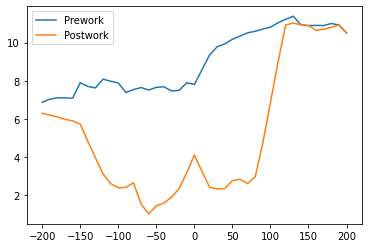

In [10]:
plt.plot(df1['Distance'], df1['prework'], label='Prework')
plt.plot(df1['Distance'], df1['workable_post'], label='Postwork')
plt.legend()

(10.0, 12.0)

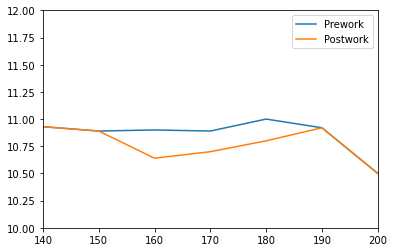

In [11]:
plt.plot(df1['Distance'], df1['prework'], label='Prework')
plt.plot(df1['Distance'], df1['workable_post'], label='Postwork')
plt.legend()
plt.xlim([140, 200])
plt.ylim([10, 12])

# Illustration of different areas in a cross section (cross section 850)

The part below is one part of the main algorithm. The target dredging area, final dreadged area, and dredged area within 
the target area are shown here

In [12]:
d_all[850].keys()

dict_keys(['chaingae', 'base', 'OFFSET', 'df', 'final_df'])

In [13]:
sample_df = d_all[key]["final_df"]
base1 = d_all[key]["base"]
offset1 = d_all[key]["OFFSET"]

In [14]:
offset1

105.0

In [15]:
dis = sample_df['As per Dredged Section']['Pre-dredge Section']['Distance'][1:-2]
prework = sample_df['As per Dredged Section']['Pre-dredge Section']['Levels'][1:-2]
postwork = sample_df['As per Dredged Section']['Post-dredged Section']['Levels'][1:-2]

design = pd.DataFrame()
design['Distance'] = dis
design['design']=base1
p_index1=int(design[design['Distance']==offset1].index.values)  # end point of the design baseline
n_index1=int(design[design['Distance']==-offset1].index.values) # starting point of the design baseline
l_index1=design.shape[0]-1   
# the slope is 1:3 on either side from the edges of the base
j=n_index1-1
while j>=1:
    
    design.loc[j,"design"]= design["design"][n_index1] + (1/3)*abs(design["Distance"][n_index1]-design["Distance"][j])
    j=j-1

k=p_index1+1
while k<=l_index1+1:
    
    design.loc[k,"design"] = design["design"][n_index1] + (1/3)*abs(design["Distance"][p_index1]-design["Distance"][k])
    k=k+1
    
dredged_within_design = sample_df['As per Dredged Section']['Dredged Section within Design']['Levels'][1:-2]

In [16]:
df2=pd.DataFrame()
df2['Distance']=dis
df2['prework']=prework
df2['postwork']=postwork
df2['design']=np.array(design['design'])
df2['design_under_prework']=np.array(design['design'])
df2.loc[df2['design']>df2['prework'],'design_under_prework']=df2[df2['design']>df2['prework']]['prework']


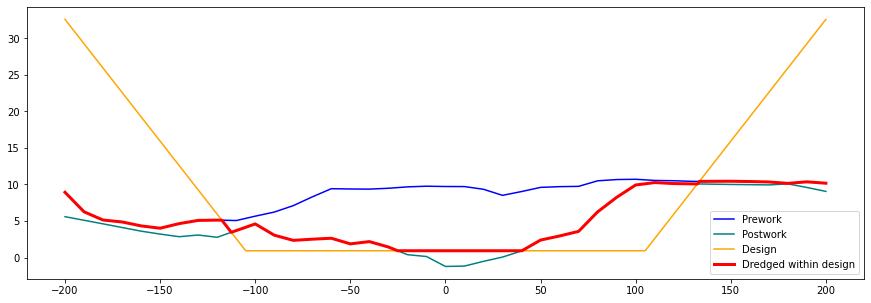

In [17]:
plt.figure(figsize=(15,5))

plt.plot(dis, prework, label ='Prework', color="blue")
plt.plot(dis, postwork, label ='Postwork',color="teal")
plt.plot(dis, design['design'], label ='Design',color="orange")
plt.plot(dis, dredged_within_design, label ='Dredged within design', color="red",linewidth=3)
plt.legend()

In [18]:
dis = np.array(dis, dtype=float)
prework = np.array(prework, dtype=float)
postwork = np.array(postwork, dtype=float)
des = np.array(design['design'], dtype=float)
dredged_within_design = np.array(dredged_within_design, dtype=float)
df2['design_under_prework'] = np.array(df2['design_under_prework'], dtype=float)

Text(0.5, 1.0, 'actual dredged area within target area')

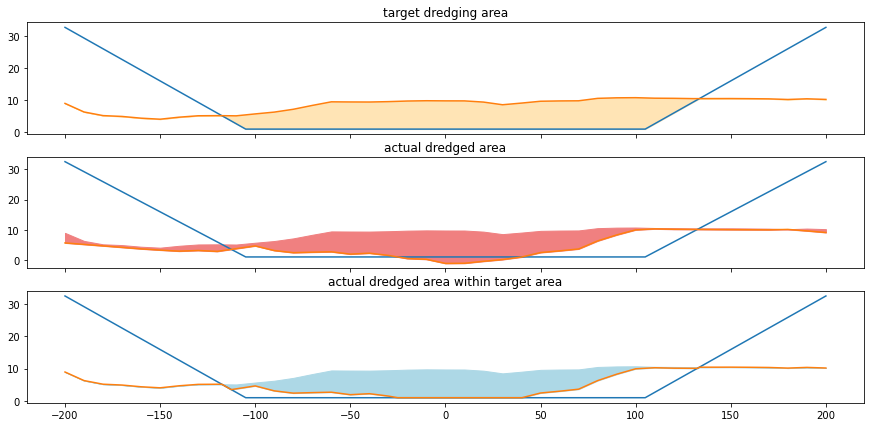

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15, 7))
ax1.plot(dis, des)
ax1.plot(dis, prework)
ax1.fill_between(dis,prework,df2['design_under_prework'], color = 'moccasin')
ax1.set_title('target dredging area')

ax2.plot(dis, des)
ax2.plot(dis, postwork)
ax2.fill_between(dis,prework,postwork, color = 'lightcoral')
ax2.set_title('actual dredged area')

ax3.plot(dis, des)
ax3.plot(dis, dredged_within_design)
ax3.fill_between(dis,prework,dredged_within_design, color = 'lightblue')
ax3.set_title('actual dredged area within target area')